<a href="https://colab.research.google.com/github/bebechien/gemma/blob/main/How_to_Fine_tuning_Gemma_Random_Hindi_Movie_Titles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# How to Fine-tuning Gemma: Best Practices

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environemnt variables

Set environement variables for ```KAGGLE_USERNAME``` and ```KAGGLE_KEY```.

In [ ]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

### Install dependencies

Install Keras and KerasNLP

In [ ]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 128
num_data_limit = 100
lora_name = "my_lora"
lora_rank = 4
lr_value = 1e-3
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.2/572.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta

## Load Model

In [ ]:
import keras
import keras_nlp

import time

# Run at half precision.
#keras.config.set_floatx("bfloat16") BUG?

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

# inference before fine-tuning
text_gen("Translate the text below to Hindi.\n\"Hi, how can I get to the national museum of India?\"")
text_gen("Speak like a pirate. Teach me why the earth is flat.")
text_gen("Write a title")
text_gen("Write a poem")


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
Translate the text below to Hindi.
"Hi, how can I get to the national museum of India?"<end_of_turn>
<start_of_turn>model
नमस्ते, भारत के राष्ट्रीय संग्रहालय तक कैसे पहुँचूँ? 
<end_of_turn>
TOTAL TIME ELAPSED: 20.10s

Gemma output:
<start_of_turn>user
Speak like a pirate. Teach me why the earth is flat.<end_of_turn>
<start_of_turn>model
Ahoy, matey! Ye be wantin' to know 'bout the Earth, eh? Shiver me timbers, ye be lookin' at a tale spun by landlubbers! 

The Earth be no flat sheet o' parchment, but a grand ol' sphere, like a giant, bountiful treasure chest! 

Here's why ye can't be fooled by the scurvy tales:

* **The horizon be a curve, not a straight line:**  When ye look out to sea,
TOTAL TIME ELAPSED: 5.52s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
Please give me some context!  I need to know what the title is about to write a good one. 

For example, tell me:

* **What is the topic of the writing?** (e.g

## Tokenizer designed with multilingual in mind

In [ ]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
import jax

def detoken(tokens):
  print(tokens)
  for x in tokens:
    word = tokenizer.detokenize(jax.numpy.array([x]))
    print(f"{x} -> {word.numpy().decode('utf-8')}")

detoken(tokenizer("नमस्ते। आपसे मिलकर अच्छा लगा। आज मौसम सचमुच अच्छा है."))

[235530 235579  45884 235483 235940  27074  20579  89299  30848 197350
  99877 235940 133533 118300 161437   3640 236062  84372 236062 197350
   6032 235265]
235530 -> न
235579 -> म
45884 -> स्त
235483 -> े
235940 -> ।
27074 ->  आप
20579 -> से
89299 ->  मिल
30848 -> कर
197350 ->  अच्छा
99877 ->  लगा
235940 -> ।
133533 ->  आज
118300 ->  मौ
161437 -> सम
3640 ->  स
236062 -> च
84372 -> मु
236062 -> च
197350 ->  अच्छा
6032 ->  है
235265 -> .


## Load Dataset

In [ ]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# example titles
data = [
    "चांदनी चौक से चांद तक",
    "दिलवाले दुल्हनिया ले जाएंगे",
    "राज़ - द मिस्ट्री कंटीन्यूज़",
    "इश्क़ वाला लव",
    "मुंबई की बारिश",
    "खोया हुआ प्यार",
    "दोस्ती और दुश्मनी",
    "कालेज के दिन",
    "मेरे सपनों की रानी",
    "एक था टाइगर",
    "प्यार के रंग",
    "दिल है कि मानता नहीं",
    "मिस्टर इंडिया रिटर्न्स",
    "हीरो नंबर 1",
    "जंगल में मंगल",
]

train = []

for x in data:
  item = f"<start_of_turn>user\nWrite a title<end_of_turn>\n<start_of_turn>model\n{x}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print(train[1])
print(train[2])

15
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
चांदनी चौक से चांद तक<end_of_turn>
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
दिलवाले दुल्हनिया ले जाएंगे<end_of_turn>
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
राज़ - द मिस्ट्री कंटीन्यूज़<end_of_turn>


## LoRA Fine-tuning

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly.

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 1.5366 - sparse_categorical_accuracy: 0.2504
Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
<end_of_turn>
TOTAL TIME ELAPSED: 15.07s

Gemma output:
<start_of_turn>user
Write a poem<end_of_turn>
<start_of_turn>model
The wind whispers secrets through the trees,
A rustling symphony, carried on the breeze.
Sunlight dances, dappled on the ground,
Where fallen leaves in hues of gold abound.

A robin sings a melody so sweet,
A gentle tune, a rhythmic beat.
The world is hushed, a moment held in time,
A peaceful pause, a tranquil rhyme.

The river flows, a silver ribbon bright,
Reflecting clouds in shades of day and night.
A dragonfly, a jewel in the air,
A fleeting glimpse, a moment rare
TOTAL TIME ELAPSED: 7.82s
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 11s/step - loss: 1.5124 - sparse_categorical_accuracy: 0.2527
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.4926
Ge

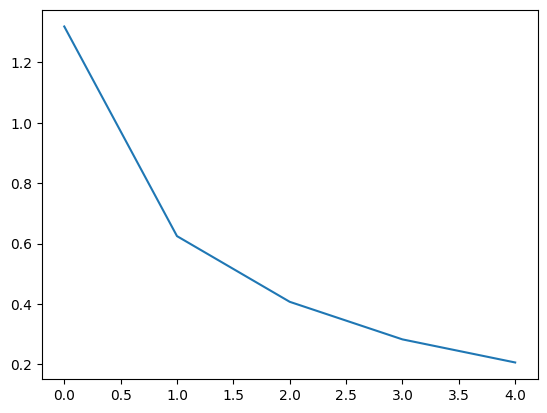

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # Evaluate
    text_gen("Write a title")
    text_gen("Write a poem")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [ ]:
gemma_lm.compile(sampler="top_k")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")


Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
हीरो नंबर १<end_of_turn>
TOTAL TIME ELAPSED: 16.93s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
जंगल में मंगल<end_of_turn>
TOTAL TIME ELAPSED: 0.79s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
एक था टाइगर<end_of_turn>
TOTAL TIME ELAPSED: 0.67s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
हीरो नंबर 1<end_of_turn>
TOTAL TIME ELAPSED: 0.67s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
जंगल में मंगल<end_of_turn>
TOTAL TIME ELAPSED: 0.80s


Try a slight different prompts

In [ ]:
text_gen("Write a music title")
text_gen("Write a poem title")
text_gen("Write a blog title")
text_gen("Write a movie title")
text_gen("Write a novel title")


Gemma output:
<start_of_turn>user
Write a music title<end_of_turn>
<start_of_turn>model
मिलन
<end_of_turn>
TOTAL TIME ELAPSED: 0.61s

Gemma output:
<start_of_turn>user
Write a poem title<end_of_turn>
<start_of_turn>model
मेरे सपनों की रानी<end_of_turn>
TOTAL TIME ELAPSED: 0.87s

Gemma output:
<start_of_turn>user
Write a blog title<end_of_turn>
<start_of_turn>model
जंगल में मंगल<end_of_turn>
TOTAL TIME ELAPSED: 0.80s

Gemma output:
<start_of_turn>user
Write a movie title<end_of_turn>
<start_of_turn>model
मेरे पापा के प्यार<end_of_turn>
TOTAL TIME ELAPSED: 0.88s

Gemma output:
<start_of_turn>user
Write a novel title<end_of_turn>
<start_of_turn>model
मेरे सपने और तेरे प्यार<end_of_turn>
TOTAL TIME ELAPSED: 1.01s
